In [151]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [175]:
class LogisticRegression():
  def __init__(self, kernel, lambd=1):
      self.kernel = kernel
      self.lambd = lambd

  def fit(self, x, y):
      # y \subset {-1, 1}
      self.x = x
      self.n = len(x)
      K = self.kernel.matrix(x, x)
      K = cp.psd_wrap(K)

      alpha = cp.Variable(self.n)
      min_objective = self.lambd * cp.quad_form(alpha, K) / 2 + cp.sum(cp.logistic(-cp.multiply(K @ alpha, y)) / self.n)
      prob = cp.Problem(cp.Minimize(min_objective))
      prob.solve()
      self.alpha = alpha.value

  def predict(self, x):
      return self.alpha @ self.kernel.matrix(self.x, x)

In [152]:
class SVM():
  def __init__(self, kernel, lambd=1):
      self.kernel = kernel
      self.lambd = lambd

  def fit(self, x, y):
      # y \subset {-1, 1}
      self.x = x
      self.n = len(x)
      K = self.kernel.matrix(x, x)
      K = cp.psd_wrap(K)

      alpha = cp.Variable(self.n)
      prob = cp.Problem(cp.Minimize(cp.quad_form(alpha, K) - 2*y @ alpha),
                        [np.diag(y) @ alpha <= np.ones(self.n) / (2*self.n*self.lambd),
                        np.diag(y) @ alpha >= np.zeros(self.n)])
      prob.solve()
      self.alpha = alpha.value

  def predict(self, x):
      return self.alpha @ self.kernel.matrix(self.x, x)

In [221]:
class MultiClassClassifier():
  def __init__(self, num_classes, model, method='one_versus_the_rest'):
      self.num_classes = num_classes
      self.method = method

      self.model = model
      self.kernel = self.model.kernel

      #if method == 'one_versus_the_rest':
      #  self.models = [model(**model_params) for i in range(num_classes)]
      #elif method == 'pairwise':
      #  self.models = [[model(**model_params) for j in range(i+1, num_classes)] for i in range(num_classes)]


  def fit(self, x, y):
      # y \subset {0, 1, ..., num_classes - 1}
      self.x = x
      self.y = y
      self.alpha = []

      if self.method == 'one_versus_the_rest':
        for i in range(self.num_classes):
          new_y = np.where(y == i, np.ones_like(y), -np.ones_like(y))
          self.model.fit(x, new_y)
          self.alpha.append(self.model.alpha)

      elif self.method == 'pairwise':
        for i in range(self.num_classes):
          self.alpha.append([])
          new_y = np.where(y == i, np.ones_like(y), -np.ones_like(y))
          for j in range(i+1, self.num_classes):
            mask = np.logical_or(y == i, y == j)
            self.model.fit(x[mask], new_y[mask])
            self.alpha[i].append(self.model.alpha)

      else:
        #directed acyclic graph
        print('Not implemented')

  def predict(self, x, return_scores=False):
      if self.method == 'one_versus_the_rest':
        for i in range(self.num_classes):
          scores = np.array(self.alpha) @ self.kernel.matrix(self.x, x)
          if return_scores:
            return scores
          return np.argmax(scores, 0)

      elif self.method == 'pairwise':
        wins_count = np.zeros((len(x), self.num_classes))
        kernel_matrix = self.kernel.matrix(self.x, x)

        for i in range(self.num_classes):
          for j in range(i+1, self.num_classes):
            mask = np.logical_or(self.y == i, self.y == j)
            score = self.alpha[i][j - i - 1] @ kernel_matrix[mask]
            wins_count[:, i] += (score > 0)
            wins_count[:, j] += (score < 0)

        return np.argmax(wins_count, -1)


In [153]:
class Kernel():
  def __init__(self, name='linear', sigma=0.1):
    self.name = name
    self.sigma = sigma

  def matrix(self, x, y):
    if self.name == 'rbf':
      K = np.exp(-np.sum((x[:, None, :] - y[None, :, :])**2, -1) / (2*self.sigma))
    if self.name == 'linear':
      K = x @ y.T

    #print(np.linalg.eigh(K))
    return K #+ np.eye(self.n) * 1e-8

## Sanity check

In [181]:
from sklearn.datasets import make_moons, make_blobs

In [155]:
data_x, data_y = make_moons(200, noise=0.1)
data_y = data_y*2 - 1

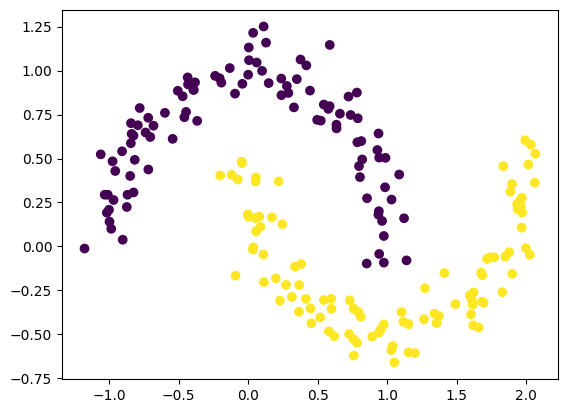

In [156]:
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y);

In [157]:
xx, yy = np.meshgrid(np.linspace(data_x[:, 0].min() - 1, data_x[:, 0].max() + 1, 100),
                     np.linspace(data_x[:, 1].min() - 1, data_x[:, 1].max() + 1, 100))
grid = np.c_[xx.flatten(), yy.flatten()]

In [144]:
simple_kernel = Kernel('rbf')
svm = SVM(simple_kernel)
svm.fit(data_x, data_y)

y_pred = svm.predict(grid).reshape(len(xx), len(yy))

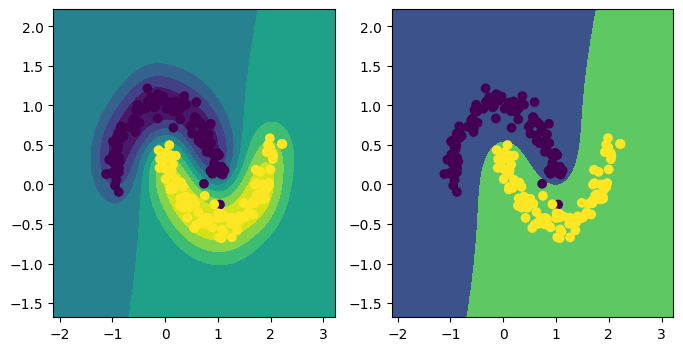

In [149]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, y_pred)#, levels=1)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y)

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, y_pred, levels=1)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y)
plt.show()

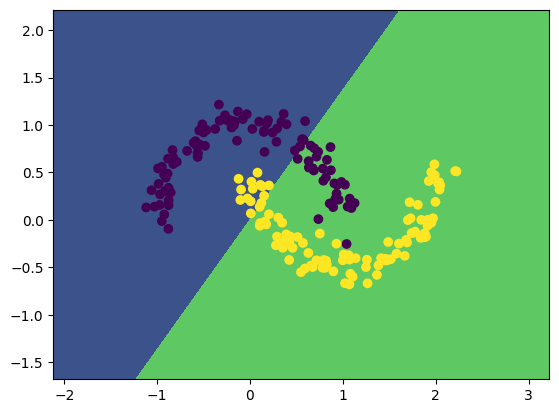

In [140]:
simple_kernel = Kernel('linear')
svm = SVM(simple_kernel)
svm.fit(data_x, data_y)

y_pred = svm.predict(grid).reshape(len(xx), len(yy))

plt.contourf(xx, yy, y_pred, levels=1)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y);

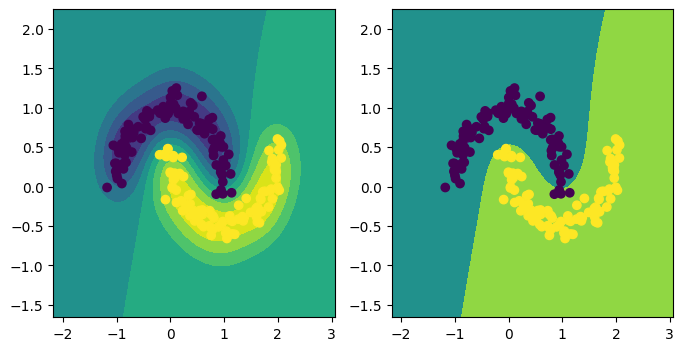

In [176]:
simple_kernel = Kernel('rbf')
lr = LogisticRegression(simple_kernel)
lr.fit(data_x, data_y)

y_pred = lr.predict(grid).reshape(len(xx), len(yy))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, y_pred)#, levels=1)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y)

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, y_pred, levels=1)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y)
plt.show()

### Multiclass classification

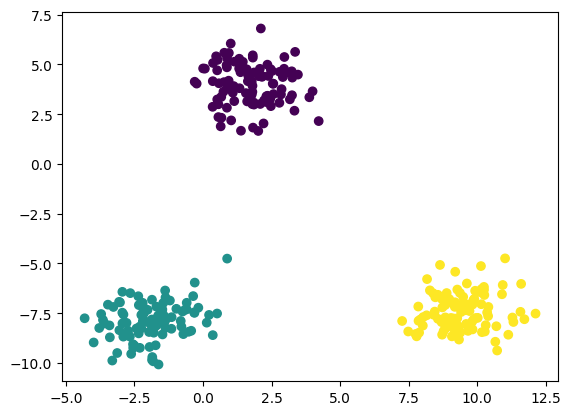

In [200]:
data_x, data_y = make_blobs(300)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y);

In [201]:
xx, yy = np.meshgrid(np.linspace(data_x[:, 0].min() - 1, data_x[:, 0].max() + 1, 100),
                     np.linspace(data_x[:, 1].min() - 1, data_x[:, 1].max() + 1, 100))
grid = np.c_[xx.flatten(), yy.flatten()]

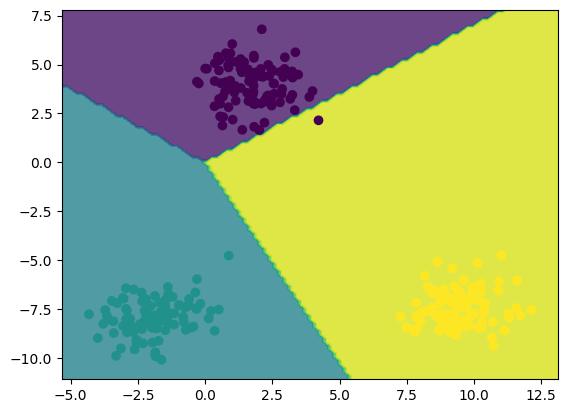

In [211]:
simple_kernel = Kernel('linear')
svm = SVM(simple_kernel)
cl = MultiClassClassifier(num_classes=3, model=svm)
cl.fit(data_x, data_y)

y_pred = cl.predict(grid).reshape(len(xx), len(yy))

plt.contourf(xx, yy, y_pred, alpha=0.8)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y)
plt.show()

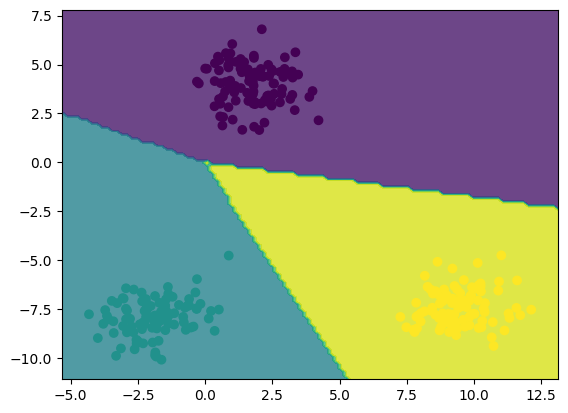

In [224]:
simple_kernel = Kernel('linear')
svm = SVM(simple_kernel)
cl = MultiClassClassifier(num_classes=3, model=svm, method='pairwise')
cl.fit(data_x, data_y)

y_pred = cl.predict(grid).reshape(len(xx), len(yy))

plt.contourf(xx, yy, y_pred, alpha=0.8)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y)
plt.show()